#### Refatorando engenharia de recursos (Feature engineering)

*Objetivo: Refatorar o experimento 2 para alinhar as etapas de extracao de recursos em um pipeline scikit-learn.*

Recursos a partir da concentração horária de CO:
- Recursos de data e hora
- Recursos de atraso
- Recursos da janela
- Recursos cíclicos
- Remover dados ausentes


In [299]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from feature_engine.creation import CyclicalFeatures
from feature_engine.datetime import DatetimeFeatures
from feature_engine.imputation import DropMissingData
from feature_engine.selection import DropFeatures
from feature_engine.timeseries.forecasting import (
    LagFeatures,
    WindowFeatures,
)

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

In [300]:
# Carregar os dados (selecionar colunas, converter index para datetime, ordenar, restrição de datas, remoção de outliers)

start_date = "2004-04-01 00:00:00"
end_date = "2005-03-31 23:59:59"
cut_date = pd.to_datetime(end_date) - pd.DateOffset(months=1)

def load_data():

    file = "../datasets/air_quality_uci.csv"

    data = pd.read_csv(
        file,
        sep=",",
        usecols=["Date_Time", "CO_sensor", "RH"],
        index_col=["Date_Time"],
    )
    data.index = pd.to_datetime(data.index, format='%d/%m/%Y %H:%M:%S')
    data.columns = data.columns.str.lower()
    data.index.name = data.index.name.lower()

    data.sort_index(inplace=True)
    data = data.loc[start_date:end_date]
    data = data.loc[(data["co_sensor"] >= 0) & (data["rh"] >= 0)]

    return data

In [301]:
# Extrair recursos de data/hora automaticamente utilizando feature-engine

dtf = DatetimeFeatures(
    variables="index",
    
    features_to_extract=[
        "month",
        "week",
        "day_of_week",
        "day_of_month",
        "hour",
        "weekend",
    ],
)


In [302]:
# adicionar recursos de Atraso (Lag features) utilizando feature-engine:

lagf = LagFeatures(
    variables=["co_sensor", "rh"],
    freq=["1H", "24H"],
    missing_values="ignore",
)

In [303]:
# Criar recursos  de janela (Window features) utilizando feature-engine:

winf = WindowFeatures(
    variables=["co_sensor", "rh"],
    window="3H",
    freq="1H",
    missing_values="ignore",
)

In [304]:
# Criar recursos para capturar ciclos diários e mensais utilizando feature-engine

cyclicf = CyclicalFeatures(
    variables=["month", "hour"],
    drop_original=False,
)

In [305]:
# Drop missing data
imputer = DropMissingData()

In [306]:
# Drop original time series

drop_ts = DropFeatures(features_to_drop=["co_sensor", "rh"])

In [307]:
pipe = Pipeline(
    [
        ("datetime_features", dtf),
        ("lagf", lagf),
        ("winf", winf),
        ("Periodic", cyclicf),
        ("dropna", imputer),
        ("drop_ts", drop_ts),
    ]
)

In [308]:
# Cima   - Pipeline de engenharia de recursos
# ==========================================
# Abaixo -  

In [309]:
# Pipeline (criar um pipeline para automatizar o processo de engenharia de recursos)
data = load_data()

data.head()

,co_sensor,rh
date_time,,
2004-04-01 00:00:00,1143.0,61.6
2004-04-01 01:00:00,1044.0,63.9
2004-04-01 02:00:00,1034.0,67.2
2004-04-01 03:00:00,956.0,73.1
2004-04-01 04:00:00,909.0,66.6


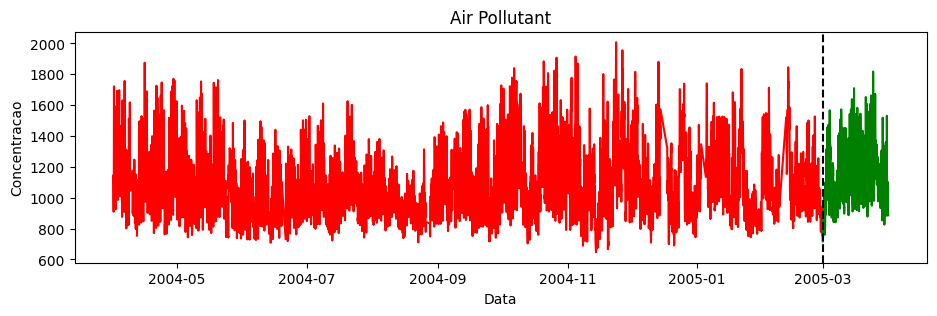

In [322]:
plt.figure(figsize=(11, 3))
plt.plot(data["co_sensor"][:cut_date], "r-")
plt.plot(data["co_sensor"][cut_date:], "g-")
plt.xlabel(xlabel="Data")
plt.ylabel(ylabel="Concentracao")
plt.title("Air Pollutant")
plt.axvline(cut_date, 0, 30, color="k", linestyle="--", label="Divisão entre treino e teste")
# plt.grid(True)
plt.show()

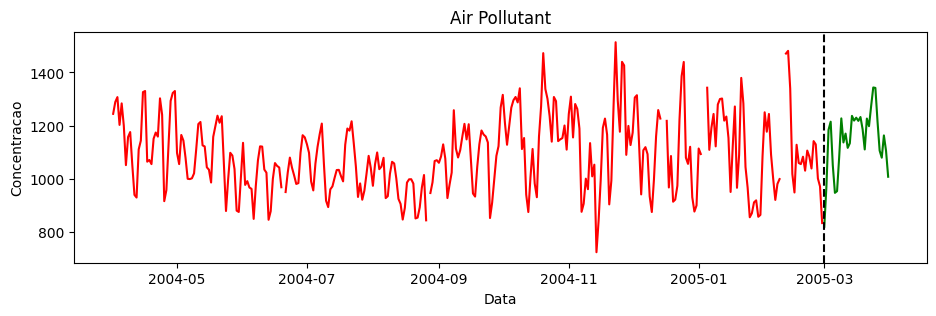

In [323]:
freq = 'D' 

# Resample dos dados para frequencia de dia
resampled_data = data["co_sensor"].resample(freq).mean()


# Preencha com zero (ou qualquer valor desejado)
resampled_data = resampled_data.fillna(0)

# Ou realize interpolação linear
# resampled_data = resampled_data.interpolate(method='linear')


plt.figure(figsize=(11, 3))
plt.plot(resampled_data[:cut_date], "r-")
plt.plot(resampled_data[cut_date:], "g-")
plt.xlabel(xlabel="Data")
plt.ylabel(ylabel="Concentracao")
plt.title("Air Pollutant")
plt.axvline(cut_date, 0, 30, color="k", linestyle="--", label="Divisão entre treino e teste")
# plt.grid(True)
plt.show()

#### **Dividir os dados em treino e teste**

Devido ao recurso de atraso de 24 horas, precisamos de dados sobre as informações sobre poluentes pelo menos 24 horas antes  
do primeiro ponto de previsão no conjunto de teste para criar recursos de entrada.

Assim, o conjunto de testes deve conter o primeiro ponto de previsão mais as 24 horas anteriores.

In [ ]:
print(data.index.min(), data.index.max())

# O último mês de dados começa em 2005-02-01.
# Mas precisamos de 24 horas de dados anteriores para criar os recursos necessários:

cut_date - pd.offsets.Hour(24)

In [ ]:
cut_date

In [ ]:
# start_date = "2004-04-01"
# end_date   = "2005-03-31"
# cut_date   = pd.to_datetime(end_date) - pd.DateOffset(months=1)

# input data
X_train = data[data.index <= cut_date]
X_test = data[data.index > cut_date - pd.offsets.Hour(24)]

# target
y_train = data[data.index <= cut_date]["co_sensor"]
y_test = data[data.index > cut_date - pd.offsets.Hour(24)]["co_sensor"]

# check
print("data   :", data.index.min(), data.index.max())
print("x_train:", X_train.index.min(), X_train.index.max())
print("x_test :", X_test.index.min(), X_test.index.max())

In [ ]:
# Criar recursos do pipiline de engenharia de recursos para o conjunto de treino:

X_train_t = pipe.fit_transform(X_train)
X_train_t.head()

In [ ]:
# Pipeline de transformação removeu observações com dados ausentes, portanto, precisamos remover essas observações também da variável de destino.

In [ ]:
y_train_t

In [ ]:
print(y_train.shape)

y_train_t = y_train.loc[X_train_t.index]

print(y_train_t.shape)

In [ ]:
# Lasso regression
model_lasso = Lasso(random_state=0)

# Train the model
model_lasso.fit(X_train_t, y_train_t)

In [ ]:
y_pred_train = lasso.predict(X_train_t)

print("train rmse: ", mean_squared_error(y_pred_train, y_train_t, squared=False,))

In [ ]:
# Verificar divisão de dados de treino e teste

print("data     :", data.index.min(), data.index.max())
print("")
print("X_train  :", X_train.index.min(), X_train.index.max())
print("X_train_t:", X_train_t.index.min(), X_train_t.index.max())
print("")
print("X_test   :", X_test.index.min(), X_test.index.max())
print("X_test_t :", X_test_t.index.min(), X_test_t.index.max())


# Observe que as 24 horas anteriores (sobreposição) de informações (X_test_t)
# desapareceu do conjunto de testes (eles tinham dados nulos).
# conjunto de dados de X_test_t contém  o primeiro ponto de previsão como esperado.

# E vale observar que o primeiro dia de X_train_t foi perdido e iniciando em 
# 2005-02-01 00:00:00 (tinham dados nulos).

In [ ]:
# Plotar o gráfico com os valores previstos e os valores reais

plt.figure(figsize=(8, 5))
plt.plot(y_train_t.index, y_train_t, label='Valor Real')
plt.plot(y_train_t.index, y_pred_train, label='Valor Previsto', alpha=0.8)
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()
plt.show()

No dataset de treino, a modelo parece estar fazendo um trabalho decente.

In [ ]:
# Avaliar modelo
# Avaliaremos o desempenho do modelo em nosso conjunto de testes agora.

X_test_t = pipe.transform(X_test)
X_test_t.head()


In [ ]:
y_test_t = y_test.loc[X_test_t.index] 

In [ ]:
y_pred_test = lasso.predict(X_test_t)

print("train rmse: ", mean_squared_error(y_pred_test, y_test_t, squared=False,))

In [ ]:
print(y_pred_test.shape)
print(y_test_t.shape)
print(X_test_t.shape)


In [ ]:
result_df = pd.DataFrame(index=X_test_t.index)
result_df['pred'] = y_pred_test
result_df['test'] = y_test_t
result_df


In [ ]:
# Plotar o gráfico com os valores previstos e os valores reais
plt.figure(figsize=(8, 5))
plt.plot(y_test_t.index, y_test_t, label='Valor Real')
plt.plot(y_test_t.index, y_pred_test, label='Valor Previsto', alpha=0.8)
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()
plt.show()



In [ ]:
# Plotar o gráfico com os valores previstos e os valores reais
plt.figure(figsize=(8, 5))
plt.plot(y_test_t.index, y_test_t, label='test')
plt.plot(y_test_t.index, y_pred_test, label='predict', alpha=0.8)
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15, 5))

plt.title("Valor real x Valor Previsto")
plt.xlabel("Data")
plt.ylabel("Consumo kw/h")

plt.plot(data.index, data[['co_sensor']], label='real')
plt.plot(y_train_t.index, y_pred_train, label='train predict', alpha=0.8)
plt.plot(y_test_t.index, y_pred_test, label='test predict', alpha=0.8)

plt.legend()
plt.grid(True)
plt.show()